In [2]:

import nibabel as nib
import scipy.ndimage as ndi


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndi.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndi.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


In [3]:
import pandas as pd
labels_df = pd.read_csv('/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/Label_file.csv')
labels_df

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,Yes,No
1,IXI448-HH-2393-T1_bet_07.nii,Yes,No
2,IXI252-HH-1693-T1_bet_08.nii,Yes,No
3,IXI188-Guys-0798-T1_bet_17.nii,Yes,No
4,IXI182-Guys-0792-T1_bet_17.nii,Yes,No
...,...,...,...
1306,IXI477-IOP-1141-T1_bse_default.nii,Yes,No
1307,IXI573-IOP-1155-T1_bse_default.nii,Yes,No
1308,IXI483-HH-2177-T1_bse_default.nii,No,Yes
1309,IXI159-HH-1549-T1_bse_default.nii,Yes,No


In [4]:
import os
files_present = os.listdir('/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files')

In [5]:
labels_files = []
for k in files_present:
    labels_files.append(labels_df[labels_df['Filename'] == k.strip('.gz')]['Recognizable-Facial-Feature'])
labels_files

[581    No
 Name: Recognizable-Facial-Feature, dtype: object,
 443    No
 Name: Recognizable-Facial-Feature, dtype: object,
 1093    No
 Name: Recognizable-Facial-Feature, dtype: object,
 977    Yes
 Name: Recognizable-Facial-Feature, dtype: object,
 507    No
 Name: Recognizable-Facial-Feature, dtype: object,
 345    No
 Name: Recognizable-Facial-Feature, dtype: object,
 49    Yes
 Name: Recognizable-Facial-Feature, dtype: object,
 296    Yes
 Name: Recognizable-Facial-Feature, dtype: object,
 1016    No
 Name: Recognizable-Facial-Feature, dtype: object,
 232    Yes
 Name: Recognizable-Facial-Feature, dtype: object,
 515    No
 Name: Recognizable-Facial-Feature, dtype: object,
 1081    No
 Name: Recognizable-Facial-Feature, dtype: object,
 186    Yes
 Name: Recognizable-Facial-Feature, dtype: object,
 1019    No
 Name: Recognizable-Facial-Feature, dtype: object,
 58    Yes
 Name: Recognizable-Facial-Feature, dtype: object,
 70    Yes
 Name: Recognizable-Facial-Feature, dtype: object,


In [6]:
normal_scan_paths = ['/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files/' + l for l in files_present]
len(normal_scan_paths)

804

In [7]:
import numpy as np
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
normal_scans

ImageFileError: Cannot work out file type of "/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files/.DS_Store"

In [12]:
labels = [1 if g == 'Yes' else 0 for g in labels_files]

In [14]:
x_train = normal_scans[:1000]
y_train = labels[:1000]
x_val = normal_scans[1000:]
y_val = labels[1000:]

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 1000 and 311.


In [15]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers

In [16]:
import random

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndi.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [17]:
#enter the train test split cell here and rename the variable in train loader and validation loader
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [18]:

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [21]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 4
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/4
500/500 - 5407s - loss: 0.2541 - acc: 0.8910 - val_loss: 0.1253 - val_acc: 0.9904 - 5407s/epoch - 11s/step
Epoch 2/4
500/500 - 5296s - loss: 0.2037 - acc: 0.9250 - val_loss: 0.3727 - val_acc: 0.7942 - 5296s/epoch - 11s/step
Epoch 3/4
500/500 - 5583s - loss: 0.1700 - acc: 0.9430 - val_loss: 0.1168 - val_acc: 0.9871 - 5583s/epoch - 11s/step
Epoch 4/4
500/500 - 4667s - loss: 0.1510 - acc: 0.9460 - val_loss: 0.6803 - val_acc: 0.8521 - 4667s/epoch - 9s/step


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

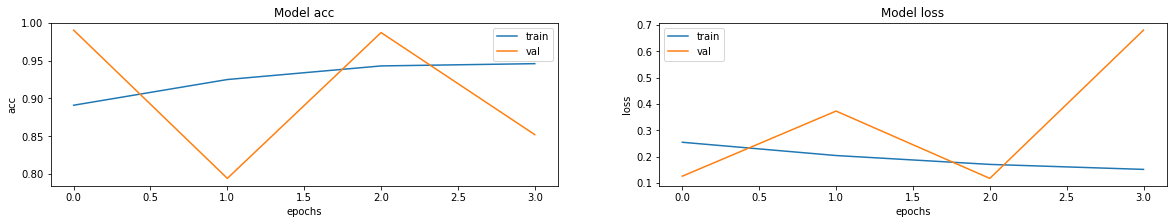

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [30]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["Recognizable-Facial-Feature", "Brain-Feature-Loss"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 2.94 percent confident that MRI scan is Recognizable-Facial-Feature
This model is 97.06 percent confident that MRI scan is Brain-Feature-Loss


In [ ]:
#we can try this insted of manually spliting the dataset
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(normal_scans, labels, test_size=0.33, random_state=42)

In [31]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        metrics.MeanSquaredError(),
        metrics.AUC(),tf.keras.metrics.Recall(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.FalseNegatives()
    ]
)

NameError: name 'metrics' is not defined